In [49]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split
matplotlib.style.use('ggplot')
import os
%matplotlib inline

os.chdir("E:\\work\\data-science\\epam-course\\classification1")
df = pd.read_excel("dataset_57_hypothyroid.xlsx")
df = df.replace('?', np.nan)

### EDA

In [50]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null float64
sex                          3622 non-null object
on_thyroxine                 3772 non-null object
query_on_thyroxine           3772 non-null object
on_antithyroid_medication    3772 non-null object
sick                         3772 non-null object
pregnant                     3772 non-null object
thyroid_surgery              3772 non-null object
I131_treatment               3772 non-null object
query_hypothyroid            3772 non-null object
query_hyperthyroid           3772 non-null object
lithium                      3772 non-null object
goitre                       3772 non-null object
tumor                        3772 non-null object
hypopituitary                3772 non-null object
psych                        3772 non-null object
TSH_measured                 3772 non-null object
TSH                          3403 non-null

In [52]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


Данные по заболеванию щитовидки и связанные с этим заболеванием показания:
числовые показатели: возраст, TSH, T3, TT4, T4U, FTI, TBG. Где T* - это гормоны. В медицинкской литературе пишут, что самые важные - это T3 и T4. Стоит проверить после построения модели вес этих характеристик. Часть данных булева, заменим их строковое представление на 0/1

In [53]:
df_ = df.dropna(how='any', axis=1)
bool_cols = []
for c in df_.columns:
    if (df_[c].dtype == np.float64):
        continue
    l1 = len(df_[df_[c].dropna(how='any').str.contains('f')])
    l2 = len(df_[df_[c].dropna(how='any').str.contains('t')])
    if (l1 * l2 > 0):
        bool_cols.append(c)
print(bool_cols)

['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']


In [54]:
for col in bool_cols:
    df[col] = df[col].replace("f", 0)
    df[col] = df[col].replace("t", 1)
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,0,0,0,0,0,0,0,0,...,1,125.0,1,1.14,1,109.0,f,NaN,SVHC,negative
1,23.0,F,0,0,0,0,0,0,0,0,...,1,102.0,0,NaN,0,NaN,f,NaN,other,negative
2,46.0,M,0,0,0,0,0,0,0,0,...,1,109.0,1,0.91,1,120.0,f,NaN,other,negative
3,70.0,F,1,0,0,0,0,0,0,0,...,1,175.0,0,NaN,0,NaN,f,NaN,other,negative
4,70.0,F,0,0,0,0,0,0,0,0,...,1,61.0,1,0.87,1,70.0,f,NaN,SVI,negative


#### Посмотрим на пропуски

In [55]:
df.apply(lambda x: sum(x.isnull()), axis=0)

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

Колонку TBG можно смело удалять

In [56]:
del df['TBG']

In [57]:
def missed_ids(data):
    ids = set()
    for i in range(0, len(data)):
        if pd.isnull(data[i]):
            ids.add(i)
    return ids

def common_missings(df, col_names):
    for col1 in col_names:
        ids1 = missed_ids(df[col1])
        for col2 in col_names:
            if (col1 == col2):
                continue
            ids2 = missed_ids(df[col2])
            print(col1 + ", " + col2 + ": " + str(len(ids1.intersection(ids2))))
        
# with_missings = ['age', 'sex', 'TSH', 'T3', 'TT4', 'FTI']
# common_missings(df, with_missings)

Посмотрим на распределение в колонках с пропусками, и произведем вставку пропущенных значений

In [58]:
from scipy.stats import shapiro

with_missings = ['age', 'sex', 'TSH', 'T3', 'TT4', 'FTI', 'T4U']
for col in with_missings:
    try:
        stat, p = shapiro(df[col])
        print(col + ' p=%.3f' % (p))
    except TypeError:
        continue

age p=1.000
TSH p=1.000
T3 p=1.000
TT4 p=1.000
FTI p=1.000
T4U p=1.000


Данные с пропусками имеют нормальное распределение. Заменим пропуски средним значением

In [59]:
for col in with_missings:
    try:
        df[col] = df[col].replace(np.nan, np.mean(df[col]))
    except TypeError:
        continue

In [60]:
df.apply(lambda x: sum(x.isnull()), axis=0)

age                            0
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                            0
T3_measured                    0
T3                             0
TT4_measured                   0
TT4                            0
T4U_measured                   0
T4U                            0
FTI_measured                   0
FTI                            0
TBG_measured                   0
referral_source                0
Class                          0
dtype: int64

150 пропусков для колонки sex. Это порядка 4% данных. Удалим эти данные

Целевая характеристика классификации - это Class. Посмотрим ее распределение 

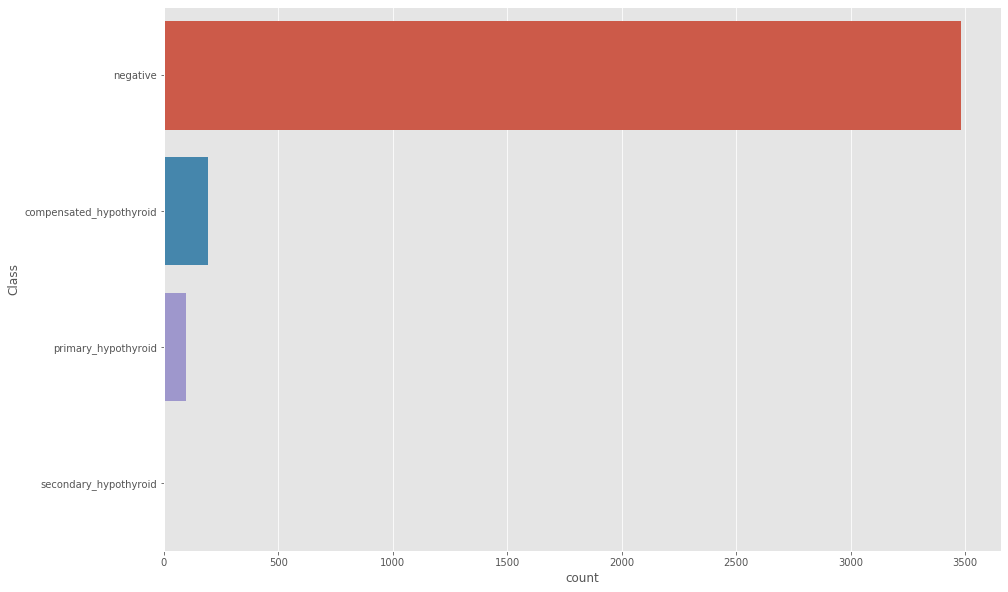

In [61]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.countplot(data=df, y='Class')

In [62]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

Класс Class является несбалансированным. Посмотрим счетчики для остальных характеристик

In [63]:
for c in df.columns:
    print(df[c].value_counts())

59.000000     95
60.000000     91
70.000000     90
73.000000     81
55.000000     81
              ..
51.735879      1
6.000000       1
5.000000       1
4.000000       1
455.000000     1
Name: age, Length: 94, dtype: int64
F    2480
M    1142
Name: sex, dtype: int64
0    3308
1     464
Name: on_thyroxine, dtype: int64
0    3722
1      50
Name: query_on_thyroxine, dtype: int64
0    3729
1      43
Name: on_antithyroid_medication, dtype: int64
0    3625
1     147
Name: sick, dtype: int64
0    3719
1      53
Name: pregnant, dtype: int64
0    3719
1      53
Name: thyroid_surgery, dtype: int64
0    3713
1      59
Name: I131_treatment, dtype: int64
0    3538
1     234
Name: query_hypothyroid, dtype: int64
0    3535
1     237
Name: query_hyperthyroid, dtype: int64
0    3754
1      18
Name: lithium, dtype: int64
0    3738
1      34
Name: goitre, dtype: int64
0    3676
1      96
Name: tumor, dtype: int64
0    3771
1       1
Name: hypopituitary, dtype: int64
0    3588
1     184
Name: psych, dtype

Другие классы также несбалансированны. Может быть, имеет смысл отфильтровать данные по счетчики. Есть некоторые значения, которые встречаются только 1 раз

In [65]:
from sklearn.preprocessing import OrdinalEncoder

classes = df.Class.dropna(how='any')
oe = OrdinalEncoder()
oe.fit(pd.DataFrame(classes))
df["Class"] = oe.fit_transform(df[["Class"]])

df_raw = df.copy()
df = df.dropna(how='any')

### Модели без балансировки

In [66]:
df = df_raw.copy()
df = df.dropna(how='any')

target = 'Class'
y = df[target]
X = df.drop(target, axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Логистическая регрессия

In [67]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

class OheTransform(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self._column_transformer = make_column_transformer(
            (OneHotEncoder(), cols)
        )
        self._cols = cols
        
    def transform(self, X, *_):
        tmp = pd.DataFrame(self._column_transformer.fit_transform(X).toarray()
                           , columns = self._column_transformer.get_feature_names())
        return pd.concat([X.drop(self._cols, axis=1), tmp], axis=1)

    def fit(self, X, *_):
        return self._column_transformer.fit(X)

class StandardScalerTransform(BaseEstimator, TransformerMixin):
    def __init__(self, df, cols):
        self._column_transformer = make_column_transformer(
            (StandardScaler(), cols)
        )
        self._cols = cols
        self._df = df
        
    def transform(self, X, *_):
        tmp = pd.DataFrame(self._column_transformer.fit_transform(X)
                           , columns = self._cols)

        for c in tmp:
            X[c] = tmp[c]
        
        return X
    
    def fit(self, *_):
        return self._column_transformer.fit(self._df)
    
    
def ohe_transormf(df, cols):
    column_trans = make_column_transformer(
        (OneHotEncoder(), columns2encode)
    )
    column_trans.fit(df)
    column_trans.get_feature_names()
    df_trans = pd.DataFrame(column_trans.fit_transform(df).toarray(), columns = column_trans.get_feature_names())
    return df_trans

cat_columns = list(df.select_dtypes(include=['category','object']))
num_columns = list(df.select_dtypes(include=['float64']))

#pipe = make_pipeline(
#    OheTransform(cat_columns)
    #, StandardScalerTransform(df, num_columns)
#    , LogisticRegression()
#)
#train_test_split(X, y, test_size=0.33, random_state=1)
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScalerTransform(df, num_columns), num_columns),
#        ('cat', OheTransform(cat_columns), cat_columns)])
#pipe = Pipeline(steps=[('preprocessor', preprocessor)])

#pipe = Pipeline(steps=[('preprocessor', preprocessor)
#                       , ('classifier', LogisticRegression())])

continuous_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('lab_enc', OneHotEncoder(handle_unknown='ignore'))])#
#continuous_transformer = StandardScaler()
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

continuous_features = list(X.select_dtypes(include=['float64']))
categorical_features = list(X.select_dtypes(include=['category', 'object']))

preprocessor = ColumnTransformer(
   transformers=[
       ('cont', continuous_transformer, continuous_features),
       ('cat', categorical_transformer, categorical_features)])

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import feature_selection

print(X_train.head())
print(y_train.head())
    # logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic = LogisticRegression(max_iter=10000)
selector = RFE(logistic)

penalty = [# 'l1' # Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
            'l2'
            #  , 'none' # UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
            # , 'elasticnet' # Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
            ]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

pipe = Pipeline(steps=[('preprocessor', preprocessor)
                        , ('RFE', selector)
                        , ('logistic', logistic)])
param_grid = {
    'logistic__penalty': penalty
    , 'logistic__C': C
}

#clf_lr = GridSearchCV(pipe, param_grid, cv=5, verbose=0, scoring='accuracy')
pipe.fit(X_train, y_train)
#selector = RFE(pipe)
#clf_lr = GridSearchCV(RFE(pipe), param_grid, cv=5, verbose=0, scoring='accuracy')
#clf_lr.fit(X_train, y_train)

       age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
3450  79.0   M             0                   0                          0   
2458  81.0   M             0                   0                          0   
1322  40.0   M             0                   0                          0   
1478  46.0   M             0                   0                          0   
3314  12.0   F             0                   0                          0   

      sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
3450     0         0                0               0                  0  ...   
2458     0         0                0               0                  0  ...   
1322     0         0                0               0                  0  ...   
1478     0         0                0               0                  0  ...   
3314     1         0                0               0                  0  ...   

      T3_measured      T3  TT4_measure

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cont',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['age', 'TSH', 'T3', 'TT4',
                                                   'T4U', 'FTI']),
                                           

In [91]:
from sklearn.metrics import classification_report
#pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.57      0.20      0.29        41
         1.0       0.95      1.00      0.97       667
         2.0       0.91      0.62      0.74        16
         3.0       0.00      0.00      0.00         1

    accuracy                           0.94       725
   macro avg       0.61      0.45      0.50       725
weighted avg       0.93      0.94      0.93       725



C:\Users\denis\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Видно, что по классу negative наилучшие значения метрик, что связано с тем,
что число характеристик, принадлежащих класс negative больше всего.
Выведем значимые характеристики, которые определил RFE

In [94]:
print("Optimal number of features : %d" % pipe['RFE'].n_features_)
print(pipe['RFE'].support_)
print(pipe['RFE'].ranking_)

Optimal number of features : 7
[False  True False  True False  True False  True False False False  True
  True  True]
[7 1 4 1 6 1 2 1 8 3 5 1 1 1]


In [95]:
print(sorted(zip(map(lambda x: round(x, 4), pipe['RFE'].ranking_), X_train.columns)))

[(1, 'goitre'), (1, 'lithium'), (1, 'query_on_thyroxine'), (1, 'sex'), (1, 'sick'), (1, 'thyroid_surgery'), (1, 'tumor'), (2, 'pregnant'), (3, 'query_hypothyroid'), (4, 'on_thyroxine'), (5, 'query_hyperthyroid'), (6, 'on_antithyroid_medication'), (7, 'age'), (8, 'I131_treatment')]


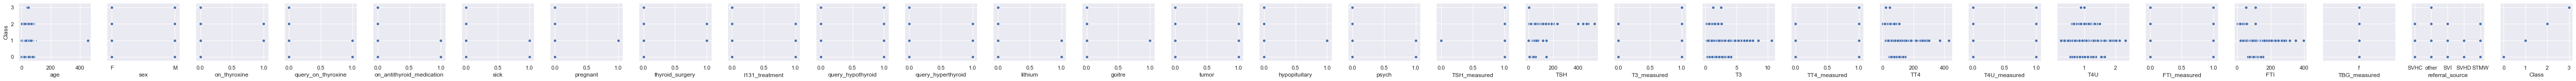

<Figure size 1080x720 with 0 Axes>

In [96]:
sns.set(color_codes=True)
sns.pairplot(df, palette="husl", y_vars=['Class'], x_vars=df.columns)
plt.figure(figsize=(15,10))
plt.show()

Выше говорилось, что T3 характеристики влияют, но в списке выбранных характеристик их нет.
Посмотрим на вывод модели с балансировкой

Построена довольно точная моель логистической регрессии, по которой наиболее важные характеристики - это
'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'I131_treatment'

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

k_range = list(range(1, 10))
param_grid_knn = {
    'knn__n_neighbors': k_range
}

knn = KNeighborsClassifier()
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor)
                       , ('knn', knn)])
#param_grid = {
#    'logistic__penalty': penalty
#    , 'logistic__C': C
#}

clf_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=3, verbose=0, scoring='accuracy')
clf_knn.fit(X_train, y_train)
#clf = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=0)
#clf.fit(X, y)

C:\Users\denis\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cont',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                       

In [98]:
best = clf_knn.best_score_
print(best)

0.9437360766939501


In [100]:
y_pred = clf_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.33      1.00      0.50         1
         3.0       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



C:\Users\denis\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Модели с балансировкой

In [101]:
import imblearn

rus = imblearn.under_sampling.RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.33, random_state=0)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         0
         3.0       0.50      1.00      0.67         1

    accuracy                           0.33         3
   macro avg       0.12      0.25      0.17         3
weighted avg       0.17      0.33      0.22         3



C:\Users\denis\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\denis\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

ValueError: n_splits=3 cannot be greater than the number of members in each class.

In [105]:
ros = imblearn.over_sampling.RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.33, random_state=0)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1095
         1.0       0.97      0.96      0.96      1026
         2.0       0.95      0.93      0.94      1152
         3.0       0.97      1.00      0.99      1139

    accuracy                           0.95      4412
   macro avg       0.95      0.95      0.95      4412
weighted avg       0.95      0.95      0.95      4412



In [106]:
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1095
         1.0       1.00      0.94      0.97      1026
         2.0       1.00      1.00      1.00      1152
         3.0       1.00      1.00      1.00      1139

    accuracy                           0.99      4412
   macro avg       0.99      0.98      0.99      4412
weighted avg       0.99      0.99      0.99      4412



Техника under сэмплирования не очень подошла к исходным данным, а модель knn с этой техникой не удалось запустить так как число классов оказалось слишком мало. Техника увеличения (Over sampling) помогла и позволила заметно увеличить качество обеих моделей

In [107]:
print(sorted(zip(map(lambda x: round(x, 4), pipe['RFE'].ranking_), X_train.columns)))

[(1, 'goitre'), (1, 'query_hypothyroid'), (1, 'query_on_thyroxine'), (1, 'sex'), (1, 'sick'), (1, 'thyroid_surgery'), (1, 'tumor'), (2, 'pregnant'), (3, 'on_thyroxine'), (4, 'on_antithyroid_medication'), (5, 'query_hyperthyroid'), (6, 'lithium'), (7, 'age'), (8, 'I131_treatment')]


Over sampling не повлиял на значения характеристик